# 5. $\gamma\gamma$ absorption

The same soft photon fields that constitute the target for Compton scattering, can absorb high-energy photons via $\gamma\gamma$ pair production.

In this tutorial, we will show how to compute the $\gamma\gamma$ opacity, $\tau_{\gamma\gamma}$, due to photon fields internal and external to the jet.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
import pkg_resources
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# import agnpy classes
from agnpy.spectra import PowerLaw
from agnpy.emission_regions import Blob
from agnpy.targets import (
    lines_dictionary,
    SphericalShellBLR,
    RingDustTorus,
    PointSourceBehindJet,
)
from agnpy.absorption import Absorption
from agnpy.utils.plot import load_mpl_rc, sed_x_label

load_mpl_rc()
tau_label = r"$\tau_{\gamma\gamma}$"

## 5.1. Absorption on the photon field external to the jet

In this first section, let us examine the absorption on photon fields external to the blob.    
Let us consider a BLR composed of three shells, emitting the ${\rm Ly\alpha}$, the ${\rm H\alpha}$, and the ${\rm H\beta}$ line.   
In the stratified BLR model of [Finke 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...830...94F/abstract) that we adopt in `agnpy`, luminosities and radii of the different shells are expressed as a fraction of those of the ${\rm H\beta}$-emitting shell.
We will therefore define first the ${\rm H\beta}$ shell and obtain the others with the scaling relations.

In [3]:
# fetch from the lines_dictionary the shells we want to use
Ly_alpha = lines_dictionary["Lyalpha"]
H_alpha = lines_dictionary["Halpha"]
H_beta = lines_dictionary["Hbeta"]

# each dictionary contains the line wavelenght and its radius and luminosity scale to the Hbeta line
print(Ly_alpha)

{'lambda': <Quantity 1215.67 Angstrom>, 'R_Hbeta_ratio': 0.27, 'L_Hbeta_ratio': 12}


In [4]:
# starts from the Hbeta shell and define the others from it
L_H_beta = 4 * 1e43 * u.Unit("erg s-1")
R_H_beta = 4.07 * 1e17 * u.cm

H_beta_blr = SphericalShellBLR(L_H_beta, 1, "Hbeta", R_H_beta)


# obtain radius and luminosity of the Ly alpha
R_Ly_alpha = R_H_beta * Ly_alpha["R_Hbeta_ratio"]
L_Ly_alpha = L_H_beta * Ly_alpha["L_Hbeta_ratio"]

Ly_alpha_blr = SphericalShellBLR(L_Ly_alpha, 1, "Lyalpha", R_Ly_alpha)


# obtain radius and luminosity of the H alpha
R_H_alpha = R_H_beta * H_alpha["R_Hbeta_ratio"]
L_H_alpha = L_H_beta * H_alpha["L_Hbeta_ratio"]

H_alpha_blr = SphericalShellBLR(L_H_alpha, 1, "Halpha", R_H_alpha)

In [5]:
print(H_beta_blr)
print(Ly_alpha_blr)
print(H_alpha_blr)

* Spherical Shell Broad Line Region:
 - L_disk (accretion disk luminosity): 4.00e+43 erg / s
 - xi_line (fraction of the disk radiation reprocessed by the BLR): 1.00e+00
 - line (type of emitted line): Hbeta, lambda = 4.86e-05 cm
 - R_line (radius of the BLR shell): 4.07e+17 cm

* Spherical Shell Broad Line Region:
 - L_disk (accretion disk luminosity): 4.80e+44 erg / s
 - xi_line (fraction of the disk radiation reprocessed by the BLR): 1.00e+00
 - line (type of emitted line): Lyalpha, lambda = 1.22e-05 cm
 - R_line (radius of the BLR shell): 1.10e+17 cm

* Spherical Shell Broad Line Region:
 - L_disk (accretion disk luminosity): 1.44e+44 erg / s
 - xi_line (fraction of the disk radiation reprocessed by the BLR): 1.00e+00
 - line (type of emitted line): Halpha, lambda = 6.56e-05 cm
 - R_line (radius of the BLR shell): 5.29e+17 cm



The absorption on external photon fields does not depend on any of the blob parameters, so we need to pass to the `Absorption` class an instance of the target and the distance from the photon field where to evaluate the absorption.   
The redshift of the host galaxy is also needed to determine the transformation of the observed frequency once we compute the opacity values.

In [6]:
r = 1e17 * u.cm

z = 1

abs_H_beta = Absorption(H_beta_blr, r=r, z=z)
abs_Ly_alpha = Absorption(Ly_alpha_blr, r=r, z=z)
abs_H_alpha = Absorption(H_alpha_blr, r=r, z=z)

As for the radiative processes, we can pass an array of frequency and obtain an array of opacity values, $\tau_{\gamma\gamma}$.

In [7]:
nu = np.logspace(24, 30, 100) * u.Hz

tau_H_beta = abs_H_beta.tau(nu)
tau_Ly_alpha = abs_Ly_alpha.tau(nu)
tau_H_alpha = abs_H_alpha.tau(nu)

/Users/cosimo/software/miniconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:614: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cosimo/software/miniconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


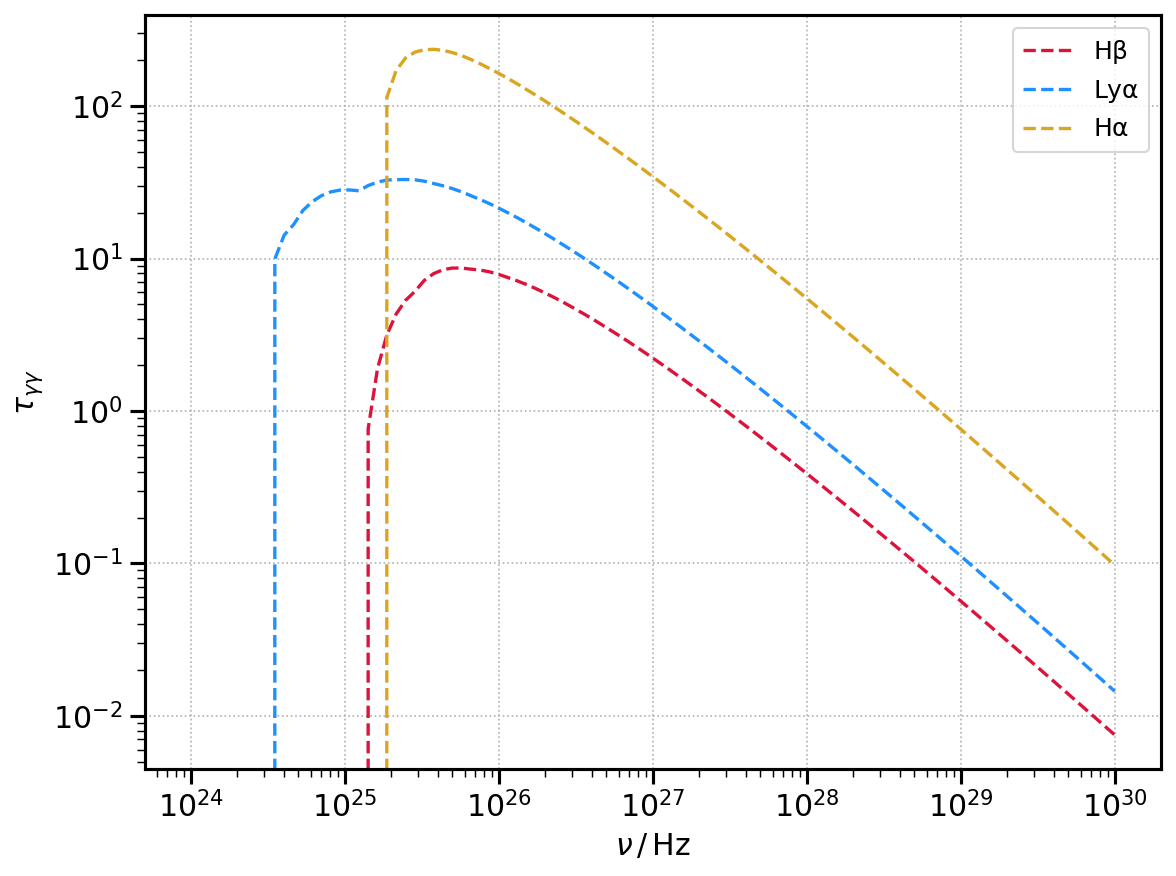

In [8]:
plt.loglog(nu, tau_H_beta, color="crimson", ls="--", label=r"${\rm H\beta}$")
plt.loglog(nu, tau_Ly_alpha, color="dodgerblue", ls="--", label=r"${\rm Ly\alpha}$")
plt.loglog(nu, tau_H_alpha, color="goldenrod", ls="--", label=r"${\rm H\alpha}$")

plt.xlabel(sed_x_label)
plt.ylabel(tau_label)
plt.legend()
plt.show()

Let us also add a dust torus and compute the absorption on its photon field.

In [9]:
# dust torus definition
L_disk = 2 * 1e46 * u.Unit("erg s-1")
csi_dt = 0.1
T_dt = 1e3 * u.K

dt = RingDustTorus(L_disk, csi_dt, T_dt)

# dust torus absorption
abs_dt = Absorption(dt, r=r, z=z)
tau_dt = abs_dt.tau(nu)

Plot the opacity due to the photon fields external to the blob.

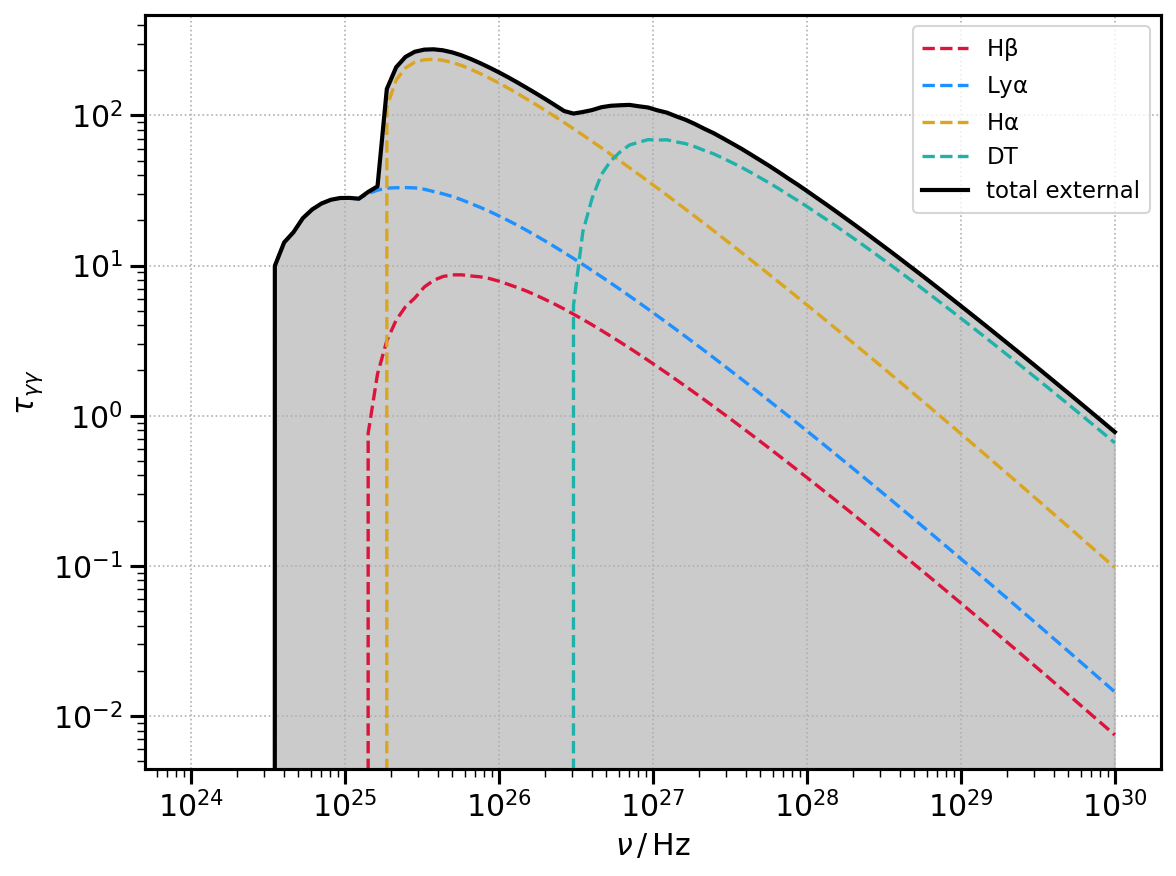

In [10]:
tau_ext = tau_H_beta + tau_Ly_alpha + tau_H_alpha + tau_dt

plt.loglog(nu, tau_H_beta, color="crimson", ls="--", label=r"${\rm H\beta}$")
plt.loglog(nu, tau_Ly_alpha, color="dodgerblue", ls="--", label=r"${\rm Ly\alpha}$")
plt.loglog(nu, tau_H_alpha, color="goldenrod", ls="--", label=r"${\rm H\alpha}$")
plt.loglog(nu, tau_dt, color="lightseagreen", ls="--", label="DT")
plt.loglog(nu, tau_ext, lw=2, color="k", label="total external")
plt.fill_between(
    nu.to_value("Hz"), np.zeros_like(nu), tau_ext, alpha=0.6, color="darkgray"
)

plt.xlabel(sed_x_label)
plt.ylabel(tau_label)
plt.legend(fontsize=11)
plt.show()

## 5.2. Opacity of photon fields internal to the blob

`agnpy` can also compute the $\gamma\gamma$ opacity due to photon fields internal to the blob, specifically to synchrotron radiation. To do it we just have to pass a `Blob` instance to the `Absorption` class.

In [11]:
# let us use a Blob with a simple power law of electrons just as an illustrative example
n_e = PowerLaw(k=1e-4 * u.Unit("cm-3"), p=2.8, gamma_min=1e2, gamma_max=1e7)

blob = Blob(n_e=n_e)

abs_synch = Absorption(blob)

tau_synch = abs_synch.tau(nu)

/Users/cosimo/software/miniconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


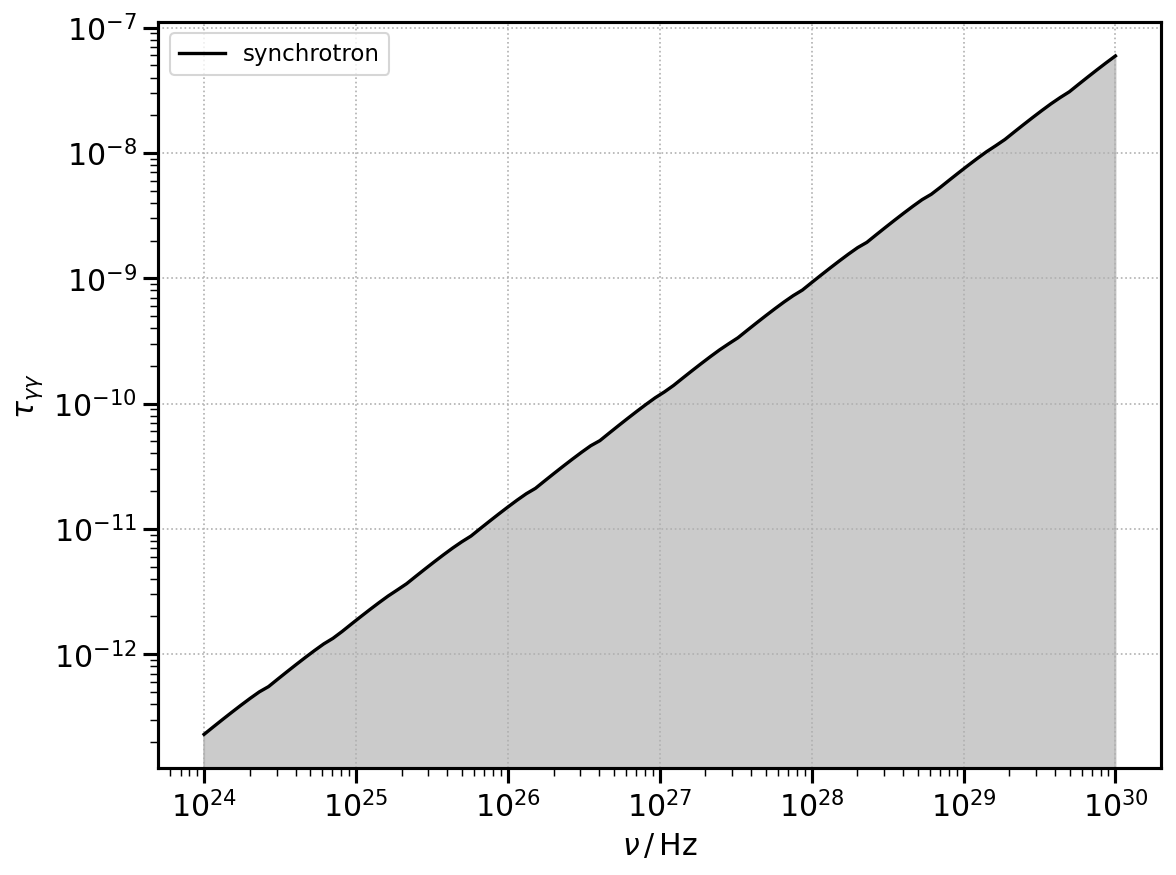

In [12]:
plt.loglog(nu, tau_synch, color="k", label="synchrotron")
plt.fill_between(
    nu.to_value("Hz"), np.zeros_like(nu), tau_synch, alpha=0.6, color="darkgray"
)

plt.xlabel(sed_x_label)
plt.ylabel(tau_label)
plt.legend(fontsize=11)
plt.show()

## 5.3. Attenuation factor

We note that **internal and external absorption correspond to different attenuation factors of the final photon spectrum**, in particular, for photon fields external to the blob we have an attenuation factor reads

$$\exp(-\tau_{\gamma\gamma}),$$

while, for photon fields internal to the blob we have an attenuation factor

$$\frac{1 - \exp(-\tau_{\gamma\gamma})}{\tau_{\gamma\gamma}}.$$

`agnpy` directly allows to compute these factors through the `Absorption.absorption` and `Absorption.absorption_homogeneous` methods. We can therefore see the actual impact of internal and external photon fields on the final high-energy spectrum.

In [13]:
# for the external absorption we multiply all the absorption factors
# (we are summing the taus)
abs_ext = (
    abs_H_beta.absorption(nu)
    * abs_Ly_alpha.absorption(nu)
    * abs_H_alpha.absorption(nu)
    * abs_dt.absorption(nu)
)

# internal absorption
abs_int = abs_synch.absorption_homogeneous(nu)

/Users/cosimo/software/miniconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:614: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


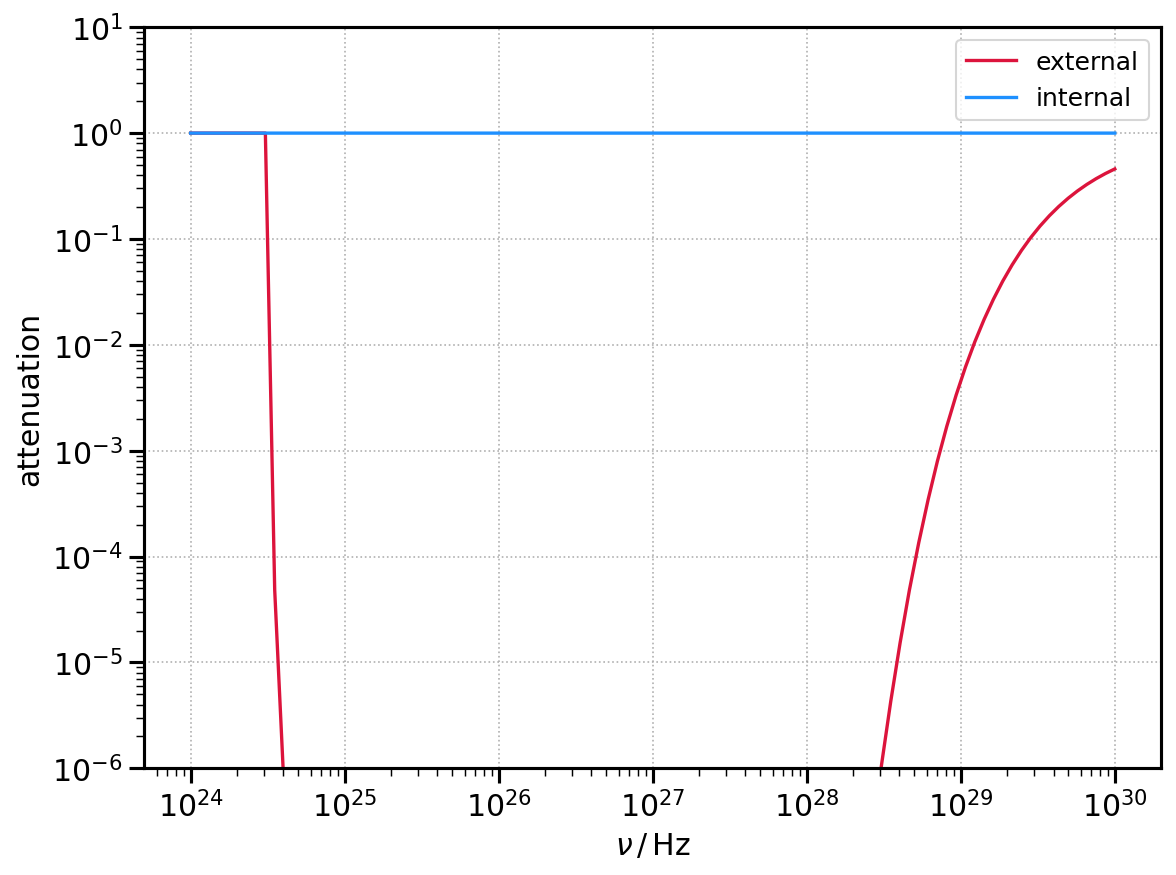

In [14]:
plt.loglog(nu, abs_ext, color="crimson", label="external")
plt.loglog(nu, abs_int, color="dodgerblue", label="internal")

plt.legend()
plt.ylabel("attenuation")
plt.xlabel(sed_x_label)

plt.ylim([1e-6, 1e1])
plt.show()

As we can see, for the distance of the blob from the central source we selected (blob inside the BLR), the spectrum would start to be strongly absorbed at $\approx 3\times10^{24}\,{\rm Hz} = 12.4\,{\rm GeV}$.

## 5.4. Exercises

### 5.4.1 Approximating the BLR with a point-like monochromatic source
For a very large distance form the BH, $r=10^{20}\,{\rm cm}$, approximate the absorption on the ${\rm Ly \alpha}$ BLR with the one produced by a point-like emitter behind the blob. 

**Note** for a viewing angle $\theta_{\rm s}\rightarrow 0$ (i.e. for a blazar) the absorption on a point-like source is $0$ (there is a factor $1-\cos\theta_{\rm s}$ that becomes null in the absorption formula). Assume for this problem a viewing angle of $10\,{\rm deg}$; note there is an extra argument in the `Absorption` class to account for the viewing angle.